In [1]:
from depolarization3qubitcode import * #Import previously defined functions - see basic 3 qubit code
import numpy as np
import time
import matplotlib.pyplot as plt

# 3-Qubit Bit Flip Code with Depolarization Errors
#### Krauss Error Channels
A density matrix $\rho$ is a semi-positive-definite ($\langle\psi|\rho|\psi\rangle \geq 0, \forall |\psi\rangle$) Hermitian matrix ($\rho\rho^{\dagger}$ = 1) with real non-negativeeigenvalues and unit trace $\text{tr}(\rho) = 1$. Evolution transformations must preserve these properties, such transformations are called completely-positive trace-preservinp (CPTP) maps:
$$
\rho' = \rho(t + \triangle t) = \sum_l K_l \rho(t) K_l^{\dagger} 
$$
$$
\sum_l K_l^\dagger K_l  = I
$$
For our first example, we will consider the depolarizing channel, where
$$
K_0 = \sqrt{1 - p_1} I, K_1 = \sqrt{\frac{p_1}{3}}X, K_2 = \sqrt{\frac{p_1}{3}}Z, K_3 = \sqrt{\frac{p_1}{3}}Y
$$
It's easy to see $\sum_l K_l^\dagger K_l  = I$. Equivalently we can say the depolarizing channel has the effect:
$$
\epsilon(\rho) = (1-p_1)\rho + \frac{p}{3}\left(X\rho X +Y \rho Y^\dagger + Z \rho Z\right) 
$$

Remember, the probability of a given density matrix $\rho$ giving outcome $i$ is
$$
p_i=\text{tr}(P_i\rho),
$$
So let's create a function to implement this

In [2]:
def depolarizing_error(rho, p, qubit=None, all=False):
    k_0 = np.sqrt(1 - p) * Identity
    k_1 = np.sqrt(p/3) * X_gate
    k_2 = np.sqrt(p/3) * Z_gate
    k_3 = np.sqrt(p/3) * Y_gate

    num_qubits = int(np.log2(rho.shape[0]))

    if all:
        for i in range(num_qubits):
            K0 = tensor_product(np.eye(2**i), k_0, np.eye(2**(num_qubits - i - 1)))
            K1 = tensor_product(np.eye(2**i), k_1, np.eye(2**(num_qubits - i - 1)))
            K2 = tensor_product(np.eye(2**i), k_2, np.eye(2**(num_qubits - i - 1)))
            K3 = tensor_product(np.eye(2**i), k_3, np.eye(2**(num_qubits - i - 1)))
        
            rho = K0 @ rho @ K0.T + K1 @ rho @ K1.T + K2 @ rho @ K2.T + K3 @ rho @ K3.conj().T
    
        return rho

    else:
        if qubit is None:
            raise ValueError("qubit must be specified when applying to specific qubit")

        K0 = tensor_product(np.eye(2**qubit), k_0, np.eye(2**(num_qubits - qubit - 1)))
        K1 = tensor_product(np.eye(2**qubit), k_1, np.eye(2**(num_qubits - qubit - 1)))
        K2 = tensor_product(np.eye(2**qubit), k_2, np.eye(2**(num_qubits - qubit - 1)))
        K3 = tensor_product(np.eye(2**qubit), k_3, np.eye(2**(num_qubits - qubit - 1)))

        rho = K0 @ rho @ K0.T + K1 @ rho @ K1.T + K2 @ rho @ K2.T + K3 @ rho @ K3.conj().T

        return rho

We just consider depolarization errors as 'gate errors'. So, after a gate is applied, the qubit will be erronus with some probability. We can see how the three qubit code does over many cycles with depolarization errors. We also apply depolarization errors on the conditional corrections (effectively conditional X gates).

In [36]:
def depolarization_3_qubit_cycle_sim(cycles=100, repetitions=1000):
    average_fidelities = np.zeros(cycles + 1)  # Initialize average fidelities to zero
    
    for _ in range(repetitions):
        # Generate initial states
        initial_density_matrix = state_to_density_matrix(ket_0)
        encoded_density = encode_logical_density_matrix(initial_density_matrix)
        
        fidelities = [1.0]  # Start with fidelity of 1 for the initial state
        current_density = encoded_density

        # Loop over cycles
        for cycle in range(cycles):
            ancilla_added_density = rho_add_ancilla_qubits(current_density)
            result, rho_post = rho_measure_rightmost_2_qubits(ancilla_added_density)
            corrected_density = rho_correct_density_matrix(rho_post, result)
            reshaped_array = corrected_density.reshape([8, 4, 8, 4])
            current_density = np.einsum('jiki->jk', reshaped_array)
            fidelity_value = np.real(fidelity(encoded_density, current_density))
            fidelities.append(fidelity_value)
        
        # Add the fidelities from this repetition to the running total
        average_fidelities += np.array(fidelities)
    
    # Calculate the average fidelities over all repetitions
    average_fidelities /= repetitions
    
    return average_fidelities

In [37]:
cycles = 30
repetitions = 1000
start_time = time.time()
average_fidelities = depolarization_3_qubit_cycle_sim(cycles=cycles, repetitions=repetitions)
end_time = time.time()

time_taken = end_time - start_time


# Print time taken
print(f"Time taken for {cycles} cycles: {time_taken:.2f} seconds")

Time taken for 30 cycles: 77.12 seconds


Note that for this example, we have encoded the state as $|000\rangle$, so the logical state won't be affected by phase errors. For this, we've set $p = 0.01$ (see depolarization3qubitcode.py).

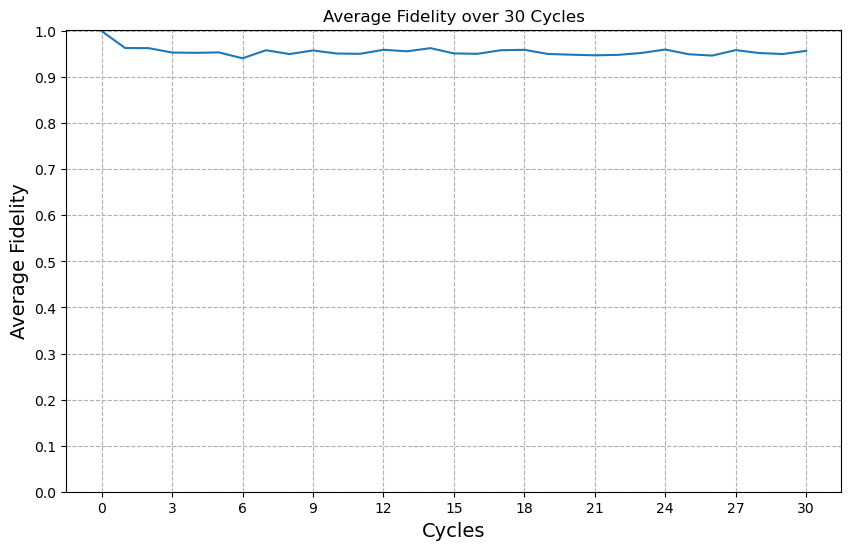

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(cycles + 1), average_fidelities,)
plt.title(f'Average Fidelity over {cycles} Cycles')
plt.xlabel('Cycles', fontsize=14)
plt.ylabel('Average Fidelity', fontsize=14)
plt.grid(True, which='both', linestyle='--')
plt.xticks(range(0, cycles + 1, max(1, cycles // 10)))
plt.yticks(np.linspace(0, 1, 11))


# Display the plot
plt.show()

This illustrates the dual continous / discrete nature of quantum errors. When a depolarization occurs, we're in a superposition of no error and error. However, when we measure our ancilla qubits, the system collapses in a definite error/no error state. For a simple example, if we just consider bit flip errors ($K_1 = \sqrt{\frac{p_1}{3}}X$), our state could be:
$$
\sqrt{0.98}|000\rangle\otimes |00\rangle + \sqrt{0.01}|010\rangle\otimes |11\rangle + \sqrt{0.01}|001\rangle\otimes|01\rangle.
$$
Then, when the ancilla qubits are measured, the result will be $|00\rangle$ 98% of the time (no error) or $|11\rangle$/$|01\rangle$ 2% of the time. So in the rare case the state collapses to an errornus state, we can still correct it as normal. However, when applying corrections, the gates will cause some depolarization error, hence a drop in fidelity. 


But this only works because we are effectively only allowing bit flip errors (as we're encoding $|0\rangle_L$), which the bit flip code is (quite) good at correcting. Now let's see how it does for a random inital state.

In [27]:
# Function to generate a random normalized quantum state
def generate_random_state():
    # Generate random complex numbers for a and b
    a = np.random.rand() + 1j * np.random.rand()
    b = np.random.rand() + 1j * np.random.rand()

    # Normalize the state
    norm_factor = np.sqrt(np.abs(a)**2 + np.abs(b)**2)
    a_normalized = a / norm_factor
    b_normalized = b / norm_factor

    return a_normalized, b_normalized

global a, b
a, b = generate_random_state()

In [28]:
def depolarization_3_qubit_cycle_sim(cycles=100, repetitions=1000):
    average_fidelities = np.zeros(cycles + 1)  # Initialize average fidelities to zero
    
    for _ in range(repetitions):
        #Create initial state
        initial_state = a * ket_0 + b * ket_1
        # Generate initial states
        initial_density_matrix = state_to_density_matrix(initial_state)
        encoded_density = encode_logical_density_matrix(initial_density_matrix)
        
        fidelities = [1.0]  # Start with fidelity of 1 for the initial state
        current_density = encoded_density

        # Loop over cycles
        for cycle in range(cycles):
            ancilla_added_density = rho_add_ancilla_qubits(current_density)
            result, rho_post = rho_measure_rightmost_2_qubits(ancilla_added_density)
            corrected_density = rho_correct_density_matrix(rho_post, result)
            reshaped_array = corrected_density.reshape([8, 4, 8, 4])
            current_density = np.einsum('jiki->jk', reshaped_array)
            fidelity_value = np.real(fidelity(encoded_density, current_density))
            fidelities.append(fidelity_value)
        
        # Add the fidelities from this repetition to the running total
        average_fidelities += np.array(fidelities)
    
    # Calculate the average fidelities over all repetitions
    average_fidelities /= repetitions
    
    return average_fidelities

Time taken for 30 cycles: 82.33 seconds


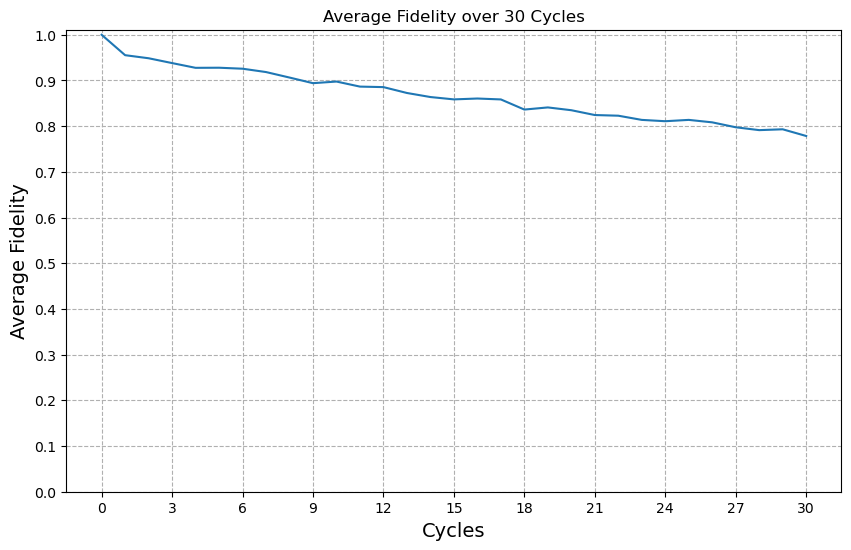

In [29]:
cycles = 30
repetitions = 1000
start_time = time.time()
average_fidelities = depolarization_3_qubit_cycle_sim(cycles=cycles, repetitions=repetitions)
end_time = time.time()

time_taken = end_time - start_time


# Print time taken
print(f"Time taken for {cycles} cycles: {time_taken:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(range(cycles + 1), average_fidelities,)
plt.title(f'Average Fidelity over {cycles} Cycles')
plt.xlabel('Cycles', fontsize=14)
plt.ylabel('Average Fidelity', fontsize=14)
plt.grid(True, which='both', linestyle='--')
plt.xticks(range(0, cycles + 1, max(1, cycles // 10)))
plt.yticks(np.linspace(0, 1, 11))


# Display the plot
plt.show()

As expected, because depolarization errors now have more ways to manifest, we see the performance of the code drops with a random initial state. 